In [1]:
%matplotlib inline

seed_value = 100
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Data uploading

In [2]:
#AIRPORT_ICAO = "ESGG"
AIRPORT_ICAO = "ESSA"

#runway = "21"
#cluster = 2

DATA_DIR = os.path.join("..", "..")
DATA_DIR = os.path.join(DATA_DIR, "data")
DATA_DIR = os.path.join(DATA_DIR, "Regression")

# WIF
filename = AIRPORT_ICAO + "_metrics_WIF_horizontal_PIs_by_hour.csv"
#filename = AIRPORT_ICAO + "_metrics_WIF_horizontal_PIs_by_hour_rwy" + runway + "_cluster" + str(cluster) +".csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_WIF_horizontal_PIs_by_hour_df = pd.read_csv(full_filename, sep=' ')

# TIF
filename = AIRPORT_ICAO + "_metrics_TIF_horizontal_PIs_by_hour.csv"
#filename = AIRPORT_ICAO + "_metrics_TIF_horizontal_PIs_by_hour_rwy" + runway + "_cluster" + str(cluster) +".csv"
full_filename = os.path.join(DATA_DIR, filename)
metrics_TIF_horizontal_PIs_by_hour_df = pd.read_csv(full_filename, sep=' ')

# Average Additional Distance

## Medians of Average Additional Distance in TMA vs TIF

                            OLS Regression Results                            
Dep. Variable:      addDistanceMedian   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                     110.7
Date:                Thu, 15 Sep 2022   Prob (F-statistic):           5.81e-06
Time:                        16:28:10   Log-Likelihood:                -14.664
No. Observations:                  10   AIC:                             33.33
Df Residuals:                       8   BIC:                             33.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1671      0.801     -3.955      0.0

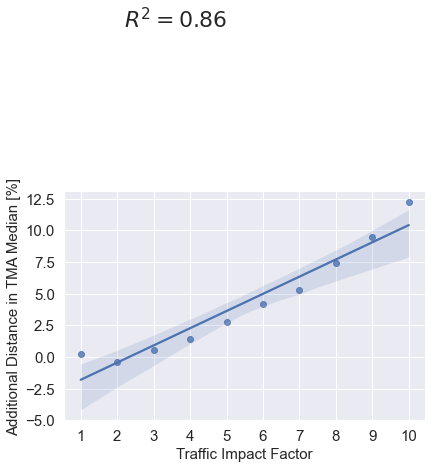

In [3]:
df = metrics_TIF_horizontal_PIs_by_hour_df.copy()
#df = df[df['numberOfFlights']>0]
p1 = df["distanceChangePercentMean"].quantile(0.05)
p2 = df["distanceChangePercentMean"].quantile(0.95)
df = df.loc[(df['distanceChangePercentMean'] > p1) & (df['distanceChangePercentMean'] < p2) ]

df.set_index(['TIF'], inplace=True)
df.sort_index(inplace=True)

median_df = pd.DataFrame(columns=['TIF', 'addDistanceMedian'])

for idx, group in df.groupby(level='TIF'):
    
    #idx_df = df.loc[idx]['additionalDistanceMedian']
    idx_df = group['distanceChangePercentMean']
    #print(len(idx_df))
    
    idx_median = np.median(idx_df)
    #median_df = median_df.append({'TIF': idx, 'addDistanceMedian': idx_median}, ignore_index=True)
    new_row = pd.DataFrame({'TIF': idx, 'addDistanceMedian': idx_median}, index=[0])
    median_df = pd.concat([median_df,new_row]).reset_index(drop=True)

median_df['TIF'] = median_df['TIF'].astype(float)
median_df['addDistanceMedian'] = median_df['addDistanceMedian'].astype(float)
    
sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='TIF',y='addDistanceMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Traffic Impact Factor', fontsize=15)
#plt.ylabel('Additional Distance in TMA Median [NM]', fontsize=15)
plt.ylabel('Additional Distance in TMA Median [%]', fontsize=15)

ticks = [i for i in range(1, 11)]
plt.xticks(ticks, fontsize=15)
plt.yticks(fontsize=15)
#plt.text(2.2, 8, '$R^2 = 0.93$', fontsize = 22)
plt.text(2.2, 26, '$R^2 = 0.86$', fontsize = 22)

#statsmodel:
X_df = median_df[['TIF']]
y_df = median_df[['addDistanceMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary())
# with outliers - ESGG: 0.84, ESSA: 0.93
# without outliers - ESGG: 0.86, ESSA: 0.93

x = X_df['TIF'].values.tolist()
y = y_df['addDistanceMedian'].values.tolist()

# calculate pearnon's correlation
pearsonr, p = stats.pearsonr(x,y) 
print(pearsonr, p)

# calculate spearman's correlation
spearmanr, p = stats.spearmanr(x, y)
print(spearmanr, p)

## Medians of Average Additional Distance in TMA vs WIF

                            OLS Regression Results                            
Dep. Variable:      addDistanceMedian   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     1.775
Date:                Thu, 15 Sep 2022   Prob (F-statistic):              0.219
Time:                        16:28:12   Log-Likelihood:                -14.115
No. Observations:                  10   AIC:                             32.23
Df Residuals:                       8   BIC:                             32.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5906      0.758      0.779      0.4

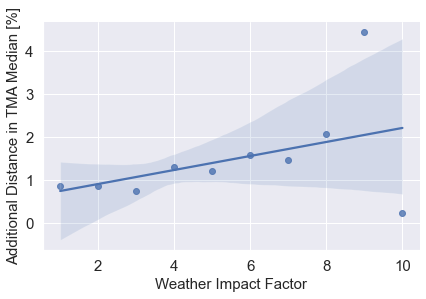

In [4]:
df = metrics_WIF_horizontal_PIs_by_hour_df.copy()
df.dropna(inplace=True)
#df = df[df['numberOfFlights']>0]
p1 = df["distanceChangePercentMean"].quantile(0.05)
p2 = df["distanceChangePercentMean"].quantile(0.95)
df = df.loc[(df['distanceChangePercentMean'] > p1) & (df['distanceChangePercentMean'] < p2) ]

df.set_index(['WIF'], inplace=True)
df.sort_index(inplace=True)

median_df = pd.DataFrame(columns=['WIF', 'addDistanceMedian'])

for idx, group in df.groupby(level='WIF'):
    
    #idx_df = df.loc[idx]['additionalDistanceMean']
    idx_df = group['distanceChangePercentMean']

    idx_median = np.median(idx_df)
            
    #median_df = median_df.append({'WIF': idx, 'addDistanceMedian': idx_median}, ignore_index=True)
    new_row = pd.DataFrame({'WIF': idx, 'addDistanceMedian': idx_median}, index=[0])
    median_df = pd.concat([median_df,new_row]).reset_index(drop=True)


median_df['WIF'] = median_df['WIF'].astype(float)
median_df['addDistanceMedian'] = median_df['addDistanceMedian'].astype(float)
    
sns.set(rc={'figure.figsize':(1,1)})

sns.lmplot(x='WIF',y='addDistanceMedian',data=median_df,fit_reg=True, height=4, aspect=3/2);
plt.xlabel('Weather Impact Factor', fontsize=15)
#plt.ylabel('Additional Distance in TMA Median [NM]', fontsize=15)
plt.ylabel('Additional Distance in TMA Median [%]', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#statsmodel:
#median_df = median_df[median_df['WIF']<10]
X_df = median_df[['WIF']]
y_df = median_df[['addDistanceMedian']]

X2 = sm.add_constant(X_df.values)
est = sm.OLS(y_df, X2)
est2 = est.fit()
print(est2.summary()) 
# with outliers - ESGG: 0.49 ESSA: 0.61
# without outliers - ESGG: 0.18 ESSA: 0.18

x = X_df['WIF'].values.tolist()
y = y_df['addDistanceMedian'].values.tolist()

# calculate pearnon's correlation
pearsonr, p = stats.pearsonr(x,y) 
print(pearsonr, p)

# calculate spearman's correlation
spearmanr, p = stats.spearmanr(x, y)
print(spearmanr, p)